In [1]:
%pylab inline
# %env CUDA_VISIBLE_DEVICES=""

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score

from keras import backend as K
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Conv1D, AvgPool1D
from keras.layers import LSTM, GRU, SimpleRNN, Bidirectional, Dense, TimeDistributed
from keras.layers import BatchNormalization, Dropout
from keras.layers import Activation
from keras.callbacks import History, TensorBoard

from tools import load_household_power_consumption, calculate_datetime_diffs
from tools import to_timeseries
from tools import split_x_y, split_train_test
from tools import vis_evaluate

from keras.utils.vis_utils import plot_model
from keras.utils.vis_utils import model_to_dot
from IPython.display import display
from IPython.display import SVG, Image

Populating the interactive namespace from numpy and matplotlib


Using TensorFlow backend.


# Configuration

In [2]:
SEQUENCE_SIZE = 64
BATCH_SIZE = 1024

# Data

In [3]:
dataset = load_household_power_consumption(hour_one_hot=True)
dataset['active_power'] = dataset['active_power'].rolling(window=16).mean()
dataset['active_power_diff1'] = dataset['active_power'].diff(-1)
dataset['active_power_diff2'] = dataset['active_power'].diff(-2)
dataset['active_power_diff3'] = dataset['active_power'].diff(-3)
dataset['active_power_diff4'] = dataset['active_power'].diff(-4)
dataset['active_power_diff5'] = dataset['active_power'].diff(-5)

dataset['active_power2'] = dataset['active_power']**2
dataset['active_power3'] = dataset['active_power']**3
dataset['active_power4'] = dataset['active_power']**4
dataset['active_power5'] = dataset['active_power']**5
dataset['active_power6'] = dataset['active_power']**6
dataset['active_power7'] = dataset['active_power']**7
dataset['active_power8'] = dataset['active_power']**8
dataset['active_power9'] = dataset['active_power']**9
dataset = dataset.dropna()

data_x, data_y = split_x_y(dataset, SEQUENCE_SIZE)
diff_x, diff_y = split_x_y(calculate_datetime_diffs(dataset), SEQUENCE_SIZE)

data_x = MinMaxScaler().fit_transform(data_x)
data_y = MinMaxScaler().fit_transform(data_y)

train_x, train_y, test_x, test_y = split_train_test(
    to_timeseries(data_x, diff_x, t=SEQUENCE_SIZE), 
    to_timeseries(data_y, diff_y, t=SEQUENCE_SIZE), 
    train_ratio=0.8)

# train_y = pad_sequences(train_y, maxlen=32, truncating='post', dtype='float32')[0]
# test_y = pad_sequences(test_y, maxlen=32, truncating='post', dtype='float32')[0]

display(dataset[['active_power', 'reactive_power', 'voltage', 'intensity', 'sub1',
                 'sub2', 'sub3', 'h_0', 'h_1', 'h_23']].head())


print('data_x:', data_x.shape)
print('data_y:', data_y.shape)
print()
print('diff_x:', diff_x.shape)
print('diff_y:', diff_y.shape)
print()
print('train_x:', train_x.shape)
print('train_y:', train_y.shape)
print()
print('test_x:', test_x.shape)
print('test_y:', test_y.shape)

2017-08-29 01:21:17,291 [hybrid-lstm.tool | INFO] Load existing dataset


,active_power,reactive_power,voltage,intensity,sub1,sub2,sub3,h_0,h_1,h_23
datetime,,,,,,,,,,
2010-10-27 13:55:00,0.542875,0.062,246.70,2.6,0.0,0.0,0.0,0,0,0
2010-10-27 13:56:00,0.544250,0.064,247.18,2.6,0.0,0.0,1.0,0,0,0
2010-10-27 13:57:00,0.546750,0.060,246.62,2.6,0.0,0.0,1.0,0,0,0
2010-10-27 13:58:00,0.552375,0.060,246.32,2.6,0.0,0.0,0.0,0,0,0
2010-10-27 13:59:00,0.558000,0.064,247.26,2.6,0.0,0.0,1.0,0,0,0


data_x: (43559, 44)
data_y: (43559, 1)

diff_x: (43559, 1)
diff_y: (43559, 1)

train_x: (34242, 64, 44)
train_y: (34242, 64, 1)

test_x: (8561, 64, 44)
test_y: (8561, 64, 1)


파란색 그래프가 보이면 안됩니다.
파란색 그래프가 보인다는 뜻은.. 데이터 전처리가 잘못 되었다는 증거


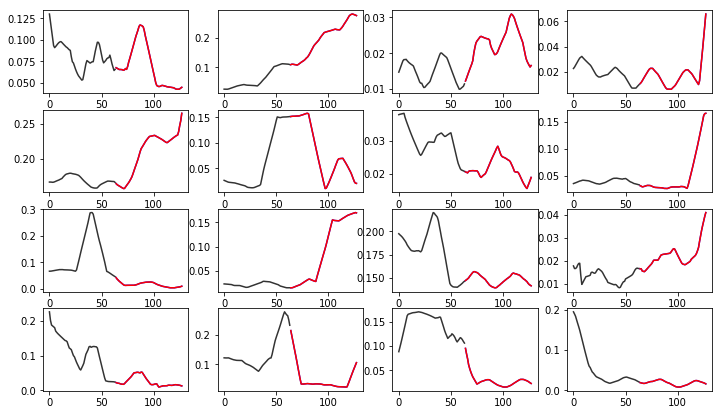

In [4]:
def vis_dataset(x, y):
    n = x.shape[0]
    seq_n = x.shape[1]
    
    fig, plots = pylab.subplots(4, 4)
    fig.set_figwidth(12)
    fig.set_figheight(7)
    plots = plots.reshape(-1)

    for p in plots:
        idx = np.random.randint(0, n)
        x1 = np.arange(seq_n)
        x2 = np.arange(seq_n, seq_n*2)
        
        p.plot(x1, x[idx, :, 0], label='input', color='#333333')
        p.plot(x2, x[idx+SEQUENCE_SIZE, :, 0], label='output', color='blue')
        p.plot(x2, y[idx, :, 0], label='output', color='red')

print('파란색 그래프가 보이면 안됩니다.')
print('파란색 그래프가 보인다는 뜻은.. 데이터 전처리가 잘못 되었다는 증거')
vis_dataset(train_x, train_y)

# Models

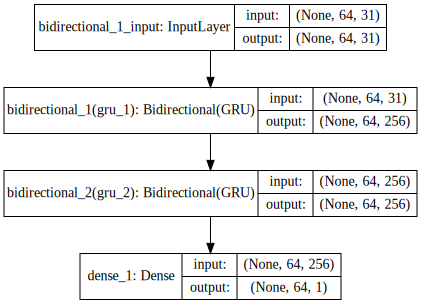

In [5]:
def r2(y_true, y_pred):
    SS_res =  K.sum(K.square( y_true-y_pred )) 
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) ) 
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

def create_model(l1=64, l2=64, n_input=31):
    np.random.seed(0)
    model = Sequential()
    model.add(Bidirectional(GRU(l1, return_sequences=True), input_shape=(SEQUENCE_SIZE, n_input)))
    model.add(Bidirectional(GRU(l1, return_sequences=True)))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy', r2])
    return model

model = create_model(128, 128)
SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

# Training

In [6]:
model = create_model(l1=256, l2=256, n_input=44)

history = History()
model.fit(train_x, train_y, epochs=12, batch_size=BATCH_SIZE, verbose=2, 
          validation_data=(test_x, test_y), callbacks=[history])

Train on 34242 samples, validate on 8561 samples
Epoch 1/12
20s - loss: 0.0609 - acc: 1.8252e-06 - r2: -3.1452e+00 - val_loss: 0.0088 - val_acc: 3.5043e-04 - val_r2: 0.1180
Epoch 2/12
18s - loss: 0.0096 - acc: 0.0000e+00 - r2: 0.3394 - val_loss: 0.0066 - val_acc: 3.5043e-04 - val_r2: 0.3190
Epoch 3/12
18s - loss: 0.0088 - acc: 0.0000e+00 - r2: 0.3948 - val_loss: 0.0064 - val_acc: 3.5043e-04 - val_r2: 0.3272
Epoch 4/12
18s - loss: 0.0086 - acc: 0.0000e+00 - r2: 0.4132 - val_loss: 0.0062 - val_acc: 3.5043e-04 - val_r2: 0.3553
Epoch 5/12
19s - loss: 0.0083 - acc: 0.0000e+00 - r2: 0.4329 - val_loss: 0.0060 - val_acc: 3.5043e-04 - val_r2: 0.3789
Epoch 6/12
18s - loss: 0.0078 - acc: 0.0000e+00 - r2: 0.4677 - val_loss: 0.0056 - val_acc: 3.5043e-04 - val_r2: 0.4123
Epoch 7/12
19s - loss: 0.0068 - acc: 4.5631e-07 - r2: 0.5370 - val_loss: 0.0051 - val_acc: 3.5043e-04 - val_r2: 0.4772
Epoch 8/12
19s - loss: 0.0058 - acc: 5.4757e-06 - r2: 0.6036 - val_loss: 0.0050 - val_acc: 3.5043e-04 - val_r2: 0

# Evaluation

In [7]:
%time eval_results = model.evaluate(test_x, test_y, batch_size=BATCH_SIZE, verbose=2)

for k, v in zip(model.metrics_names, eval_results):
    print(f'{k}: {v}')

CPU times: user 1.68 s, sys: 296 ms, total: 1.97 s
Wall time: 1.7 s
loss: 0.004305552617871833
acc: 0.00035042635206167504
r2: 0.5487453697329577


[7552] r^2: -5.974      
[6748] r^2: -156.7      
[6550] r^2: -13.22      
[4230] r^2: 0.4122      
[1043] r^2: -151.4      
[858 ] r^2: -54.51      
[3261] r^2: -0.7054     
[4155] r^2: -1.398      
[6263] r^2: 0.4351      
[3492] r^2: -0.2568     
[5651] r^2: 0.05834     
[4745] r^2: -4.64       
[598 ] r^2: -2.797      
[1442] r^2: -1.807      
[3185] r^2: -13.41      
[4835] r^2: 0.5861      


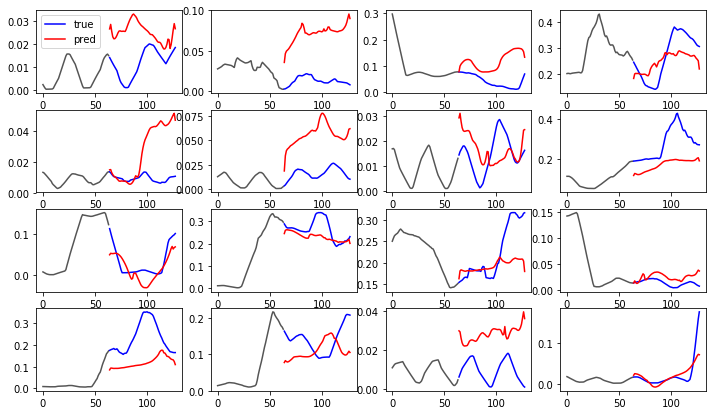

In [9]:
vis_evaluate(model, test_x, test_y, batch=BATCH_SIZE)